# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> Data Science 2: Advanced Topics in Data Science 
## Homework 5 (209): Embeddings


**Harvard University**<br/>
**Spring 2023**<br/>
**Instructors**: Mark Glickman & Pavlos Protopapas


<hr style="height:2pt">

In [1]:
# RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get(
    "https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/"
    "content/styles/cs109.css"
).text
HTML(styles)

<hr>

#### Instructions
- To submit your assignment follow the instructions given in Canvas.
- Plots should be legible and interpretable without having to refer to the code that generated them, including labels for the $x$- and $y$-axes as well as a descriptive title and/or legend when appropriate.
- When asked to interpret a visualization, do not simply describe it (e.g., "the curve has a steep slope up"), but instead explain what you think the plot *means*.
- Autograding tests are mostly to help you debug. The tests are not exhaustive so passing a test is necessary but not sufficient for full credit. 
- The use of *extremely* inefficient or error-prone code (e.g., copy-pasting nearly identical commands rather than looping) may result in only partial credit.
- We have tried to include all the libraries you may need to do the assignment in the imports cell provided below. Please get course staff approval before importing any additional 3rd party libraries.
- Enable scrolling output on cells with very long output.
- Feel free to add additional code or markdown cells as needed.
- Ensure your code runs top to bottom without error and passes all tests by restarting the kernel and running all cells (note that this can take a few minutes). 
- **You should do a "Restart Kernel and Run All Cells" before submitting to ensure (1) your notebook actually runs and (2) all output is visible**

<hr>

In [2]:
import requests
import urllib
import re
import os
import zipfile
import collections
import numpy as np
import pandas as pd
import urllib.request
import matplotlib.pyplot as plt
from collections import defaultdict
%matplotlib inline
from IPython.core.display import HTML

import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer

from sklearn.model_selection import train_test_split

2023-04-20 20:49:06.932297: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-20 20:49:06.984457: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-20 20:49:11.609020: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


**Verify Setup**

In [3]:
# Enable/Disable Eager Execution
# Reference: https://www.tensorflow.org/guide/eager
# TensorFlow's eager execution is an imperative programming environment that evaluates operations immediately, 
# without building graphs

#tf.compat.v1.disable_eager_execution()
#tf.compat.v1.enable_eager_execution()

print("tensorflow version", tf.__version__)
print("keras version", tf.keras.__version__)
print("Eager Execution Enabled:", tf.executing_eagerly())

# Get the number of replicas 
strategy = tf.distribute.MirroredStrategy()
print("Number of replicas:", strategy.num_replicas_in_sync)

devices = tf.config.experimental.get_visible_devices()
print("Devices:", devices)
print(tf.config.experimental.list_logical_devices('GPU'))

print("GPU Available: ", tf.config.list_physical_devices('GPU'))
print("All Physical Devices", tf.config.list_physical_devices())

# Better performance with the tf.data API
# Reference: https://www.tensorflow.org/guide/data_performance
AUTOTUNE = tf.data.experimental.AUTOTUNE

tensorflow version 2.12.0
keras version 2.12.0
Eager Execution Enabled: True


2023-04-20 20:49:21.132867: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-20 20:49:21.163027: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-20 20:49:21.163362: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of replicas: 1
Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]
GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
All Physical Devices [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


<div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA">

## **PART 1: Word2Vec from scratch** 
<br /><br />

<a id="part2intro"></a>
<h2> Problem Statement </h2>
<br /><br />


Word2Vec architecture allows us to get *contextual* representations of word tokens.     
<br /><br />
There are several methods to build a word embedding. We will focus on the SGNS architecture. 
![](https://storage.googleapis.com/public_colab_images/nlp/word2vec01.png)    
<br /><br />
In this problem, you are asked to build and analyze a Word2Vec architecture trained on wikipedia articles.

</div>

<div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA">


<br />
    
### **1.1 MODEL PROCESSING**
<br />
    
**1.1.1 Get the data:**    

- Get the data from the `text8.zip` file.
    `text8.zip` is a small, *cleaned* subset of a large corpus of data scraped from wikipedia pages.
    It is usually used to quickly train, or test language models.
    
- Split the data by whitespace print the first 10 words to check if has been correctly loaded.
    
**NOTE** : For this part of the homework, all words will be in their lowercase for simplicity of analysis 

    
</div>

In [4]:
# Helper code to read the data

# Download
urllib.request.urlretrieve("https://github.com/dlops-io/datasets/releases/download/v1.0/text8.zip", "text8.zip")

# Unzip and read data
filename = 'text8.zip'
with zipfile.ZipFile(filename) as f:
    vocabulary = tf.compat.as_str(f.read(f.namelist()[0])).split()

<div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA">

**1.1.2 Build the dataset**  

- Write a function that takes the `vocabulary_size` and `corpus` as input, and outputs:
    - Tokenized data
    - count of each token
    - A dictionary that maps words to tokens
    - A dictionary that maps tokens to words
    You can use the same function used in **Lab 3**, or else you can use [`tf.keras.Tokenizer`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer) to write a similar function.
- Print the first 10 tokens and reverse them to words to confirm a match to the initial print above.
     
  
Eg. `corpus[:10] = ['this','is,'an','example',...]`

`data[:10] = [44,26,24,16,...]`
    
`reversed_data =['this','is,'an','example',...]`

**NOTE**: Choose a sufficiently large vocabulary size. i.e `vocab_size>= 1000`    
<br />
    
</div>

In [5]:
import pickle

In [6]:
def build_dataset(words, n_words):
    """Process raw inputs into a dataset.""" 
    tokenizer = Tokenizer(num_words=n_words, oov_token="<OOV>")
    tokenizer.fit_on_texts(words)

    # Tokenize the words
    tokenized_data = tokenizer.texts_to_sequences(words)
    tokenized_data = [item for sublist in tokenized_data for item in sublist]  # Flatten the list

    # Count of each token
    count = tokenizer.word_counts
    count = sorted(count.items(), key=lambda x: x[1], reverse=True)
    count = count[:n_words]

    # Dictionaries for word-to-token and token-to-word mapping
    word_to_token = tokenizer.word_index
    token_to_word = tokenizer.index_word
    
    # save tokenizer to file
    with open('tokenizer.pickle', 'wb') as handle:
        pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

    return tokenized_data, count, word_to_token, token_to_word

In [7]:
%%time
vocab_size = 10000
data, count, dictionary, reverse_dictionary = build_dataset(vocabulary,
                                                                vocab_size)
del vocabulary  # Hint to reduce memory.

CPU times: user 3min 10s, sys: 1.01 s, total: 3min 11s
Wall time: 3min 11s


In [8]:
print("Tokenized data (first 10 tokens):", data[:10])
reversed_data = [reverse_dictionary[token] for token in data[:10]]
print("Reversed data (first 10 words):", reversed_data)

Tokenized data (first 10 tokens): [5235, 3082, 13, 7, 196, 3, 3135, 47, 60, 157]
Reversed data (first 10 words): ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']


<div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA">

**1.1.3 Build skipgrams with negative samples:**  
- Use the `tf.keras.preprocessing.sequence.skipgrams` function to build positive and negative samples \
    for word2vec training. Follow the documentation on how to make the pairs, or see Lab 3 for an example.
- You are free to choose your own `window_size`, but we recommend a value of 3.
- Print 10 pairs of *center* and *context* words with their associated labels.    
    
**Skip-gram Sampling table**
A large dataset means larger vocabulary with higher number of more frequent words such as stopwords. Training examples obtained from sampling commonly occurring words (such as the, is, on) don't add much useful information for the model to learn from. [Mikolov et al.](https://papers.nips.cc/paper/2013/file/9aa42b31882ec039965f3c4923ce901b-Paper.pdf) suggest subsampling of frequent words as a helpful practice to improve embedding quality.

The `tf.keras.preprocessing.sequence.skipgrams` function accepts a sampling table argument to encode probabilities of sampling any token. You can use the `tf.keras.preprocessing.sequence.make_sampling_table` to generate a word-frequency rank based probabilistic sampling table and pass it to skipgrams function.    

</div>

In [9]:
# Your code here

from tensorflow.keras.preprocessing.sequence import skipgrams, make_sampling_table

# Parameters
window_size = 3
negative_samples = 1.0

# Create a word-frequency rank-based probabilistic sampling table
sampling_table = make_sampling_table(vocab_size)

# Generate skipgrams
pairs, labels = skipgrams(
    data,
    vocabulary_size=vocab_size,
    window_size=window_size,
    negative_samples=negative_samples,
    sampling_table=sampling_table,
)

# Print 10 pairs of center and context words with their associated labels
for i in range(10):
    center_word = reverse_dictionary[pairs[i][0]]
    context_word = reverse_dictionary[pairs[i][1]]
    label = labels[i]
    print(f"({center_word}, {context_word}): {label}")

(suburban, of): 1
(marketed, by): 1
(inexpensive, attributes): 0
(biography, project): 1
(valley, way): 1
(residence, lim): 0
(tamil, sri): 1
(chip, founding): 0
(similar, except): 1
(whitlam, relationship): 1


<div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA">

**1.1.4 Conceptual question** 
    
What is the difference between using a sampling table and not using a sampling table while building the dataset for skipgrams?
(Answer in less than 200 words)
    
</div>

**Type your answer here**

Using a sampling table when building the dataset for skipgrams can significantly improve the quality of word embeddings by adjusting the sampling probabilities of words according to their frequencies in the corpus. Essentially the differences between using one and not using one can be summarized as follows:

With a sampling table, frequent words (such as stopwords) are subsampled, reducing their occurrence in the generated skipgram pairs. This helps the model focus on learning more meaningful semantic and syntactic relationships between less frequent words, which often carry more information.
Also, without a sampling table, all words in the corpus have an *equal probability of being sampled*, regardless of their frequencies. This may result in a higher number of training examples with frequent words that don't contribute much useful information for the model to learn from.

<div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA">

**1.2** **Building a word2vec model:** 

Build a word2vec model architecture based on the schematic below.
<center>
    <img src="https://storage.googleapis.com/public_colab_images/nlp/word2vec02.png" alt="centered image" width="200"/>
</center>    
    
- To do so, you will need:
    - `tf.keras.layers.Embedding` layer
    - `tf.keras.layers.Dot()`
    - `tf.keras.Model()` which is the functional API
- You can choose an appropriate embedding dimension
- Compile the model using `binary_crossentropy()` function and an appropriate optimizer. 
- Sufficiently train the model.
    - Your model will be sufficiently trained when? (Check with Ignacio)    
- Save model weights using the `model.save_weights()` for analysis of **2.3**. (More information on saving your weights [here](https://www.tensorflow.org/tutorials/keras/save_and_load) 
    
</div>

In [10]:
# Your code here

from tensorflow.keras.layers import Input, Embedding, Dot, Reshape, Dense

# Model parameters
embedding_dim = 100
epochs = 5

# Input layers for center and context words
center_word_input = Input(shape=(1,), name="center_word_input")
context_word_input = Input(shape=(1,), name="context_word_input")

# Embedding layers for center and context words
center_word_embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=1, name="center_word_embedding")(center_word_input)
context_word_embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=1, name="context_word_embedding")(context_word_input)

# Dot product of center and context word embeddings
dot_product = Dot(axes=-1, normalize=False, name="dot_product")([center_word_embedding, context_word_embedding])
dot_product = Reshape((1,), name="dot_product_reshape")(dot_product)

# Dense output layer with sigmoid activation
output = Dense(1, activation="sigmoid", name="output")(dot_product)

# Create the model
word2vec_model = Model(inputs=[center_word_input, context_word_input], outputs=output)
word2vec_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Print model summary
word2vec_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 center_word_input (InputLayer)  [(None, 1)]         0           []                               
                                                                                                  
 context_word_input (InputLayer  [(None, 1)]         0           []                               
 )                                                                                                
                                                                                                  
 center_word_embedding (Embeddi  (None, 1, 100)      1000000     ['center_word_input[0][0]']      
 ng)                                                                                              
                                                                                              

In [11]:
# Train the model
# x = np.array(pairs, dtype=np.int32)
# y = np.array(labels, dtype=np.float32)
# word2vec_model.fit([x[:, 0], x[:, 1]], y, epochs=epochs, batch_size=256, verbose=1)

In [12]:
# Save the model weights
# word2vec_model.save_weights("word2vec_model_weights.h5")

In [13]:
# Rebuild the model architecture (same as before)
center_word_input = Input(shape=(1,), name="center_word_input")
context_word_input = Input(shape=(1,), name="context_word_input")

center_word_embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=1, name="center_word_embedding")(center_word_input)
context_word_embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=1, name="context_word_embedding")(context_word_input)

dot_product = Dot(axes=-1, normalize=False, name="dot_product")([center_word_embedding, context_word_embedding])
dot_product = Reshape((1,), name="dot_product_reshape")(dot_product)

output = Dense(1, activation="sigmoid", name="output")(dot_product)

word2vec_model_loaded = Model(inputs=[center_word_input, context_word_input], outputs=output)
word2vec_model_loaded.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Load the saved weights
word2vec_model_loaded.load_weights("word2vec_model_weights.h5")

In [14]:
word2vec_model_loaded

<div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA">

### **1.3 POST-TRAINING ANALYSIS**
<br />
    
This segment involves some simple analysis of your trained embeddings.
<br />
    
**1.3.1 Vector Algebra on Embeddings**

Assuming you have chosen a sufficiently large `vocab_size`, find the embeddings for:
    
1. King
2. Male
3. Female
4. Queen
    
Find the vector `v = King - Male + Female` and find its `cosine_similarity()` with the embedding for 'Queen'.
You can use the `cosine_similarity()` function defined in [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html), and to learn more about cosine similarity, you can [read about it on wikipedia](https://en.wikipedia.org/wiki/Cosine_similarity).


**NOTE**:The `cosine_similarity()` value, must be greater than `0.9`; If it is not, this implies that your word2vec embeddings are not well-trained.

Write a function `most_similar()`, which finds the top-n words most similar to the given word.
    - Use this function to find the words most similar to `king`.
    
**Conceptual Question** Why can't we use `cosine_similarity()` as a `loss_function`?
(Answer in less than 200 words) 
    
<br />
    
</div>

`cosine_similarity()` is a similarity metric that measures the cosine of the angle between two vectors in a high-dimensional space. It is a measure of similarity, not a loss function. A loss function quantifies the difference between the predicted and actual values of a model, and it is used to train the model to reduce this difference.

The output of `cosine_similarity()` ranges from -1 to 1, with 1 indicating perfect similarity and -1 indicating perfect dissimilarity. A loss function, on the other hand, typically measures the difference between two values, and the output can be any positive value.

Therefore, `cosine_similarity()` cannot be used as a loss function. 

In [15]:
# Your code here

from tensorflow.keras.preprocessing.sequence import skipgrams
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.metrics.pairwise import cosine_similarity

# Define the vocabulary size
vocab_size = 10000

# Load the saved model and tokenizer
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

# Extract the embeddings for the center words
center_word_embeddings = word2vec_model_loaded.get_layer("center_word_embedding").get_weights()[0]

# Get the indices of the words in the vocabulary
word_to_id = tokenizer.word_index
king_id = word_to_id['king']
male_id = word_to_id['male']
female_id = word_to_id['female']
queen_id = word_to_id['queen']

# Get the embeddings for the words
king_embedding = center_word_embeddings[king_id]
male_embedding = center_word_embeddings[male_id]
female_embedding = center_word_embeddings[female_id]
queen_embedding = center_word_embeddings[queen_id]

# Calculate the vector v
v = king_embedding - male_embedding + female_embedding

# Calculate the cosine similarity between v and the embedding for 'Queen'
similarity = cosine_similarity([v], [queen_embedding])
print(f"Cosine similarity between 'v' and 'Queen': {similarity[0][0]}")

# Function to find the top-n words most similar to the given word
def most_similar(word, word_embeddings, word_to_id, id_to_word, n=5):
    query_embedding = word_embeddings[word_to_id[word]]
    similarities = cosine_similarity([query_embedding], word_embeddings)[0]
    top_n_indices = similarities.argsort()[-n-1:-1][::-1]
    return [id_to_word[i] for i in top_n_indices]

# Find the words most similar to 'king'
similar_words = most_similar('king', center_word_embeddings, word_to_id, tokenizer.index_word)
print(f"Words most similar to 'king': {similar_words}")


Cosine similarity between 'v' and 'Queen': 0.7032557129859924
Words most similar to 'king': ['crowned', 'vii', 'xiv', 'reigned', 'baldwin']


<div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA">


**1.3.2 Visualizing Embeddings**

Find the embeddings for the words:
1. 'Six'
2. 'Seven'
3. 'Eight'
4. 'Nine'
    
Find the `cosine_similarity()` of 'six' with each of 'seven`,'eight','nine' (which should be high values).
    
Reset your network (make sure your trained weights are saved), and again compute the `cosine_similarity()` values. The values should be small (because the embeddings are random).
    
Use a demonstrative plot to show the `before & after` of the 4 embeddings. Here are some suggestions: 
    1. PCA/TSNE for dimensionality reduction
    2. Radar plot to show all embedding dimensions
    
</div>

In [16]:
# Your code here

# Get the indices of the words in the vocabulary
six_id = tokenizer.word_index['six']
seven_id = tokenizer.word_index['seven']
eight_id = tokenizer.word_index['eight']
nine_id = tokenizer.word_index['nine']

# Get the embeddings for the words
six_embedding = center_word_embeddings[six_id]
seven_embedding = center_word_embeddings[seven_id]
eight_embedding = center_word_embeddings[eight_id]
nine_embedding = center_word_embeddings[nine_id]

# Calculate the cosine similarities
similarity_seven = cosine_similarity([six_embedding], [seven_embedding])[0][0]
similarity_eight = cosine_similarity([six_embedding], [eight_embedding])[0][0]
similarity_nine = cosine_similarity([six_embedding], [nine_embedding])[0][0]
print(f"Cosine similarity between 'six' and 'seven': {similarity_seven}")
print(f"Cosine similarity between 'six' and 'eight': {similarity_eight}")
print(f"Cosine similarity between 'six' and 'nine': {similarity_nine}")

Cosine similarity between 'six' and 'seven': 0.9116920828819275
Cosine similarity between 'six' and 'eight': 0.9178446531295776
Cosine similarity between 'six' and 'nine': 0.8551703691482544


In [17]:
# Reset the network
word2vec_model_loaded.get_layer('center_word_embedding').set_weights([np.random.rand(vocab_size, 100)])

# Get the embeddings for the words
center_word_embeddings = word2vec_model_loaded.get_layer('center_word_embedding').get_weights()[0]
six_embedding_random = center_word_embeddings[six_id]
seven_embedding_random = center_word_embeddings[seven_id]
eight_embedding_random = center_word_embeddings[eight_id]
nine_embedding_random = center_word_embeddings[nine_id]

# Calculate the cosine similarities
similarity_seven_random = cosine_similarity([six_embedding_random], [seven_embedding_random])[0][0]
similarity_eight_random = cosine_similarity([six_embedding_random], [eight_embedding_random])[0][0]
similarity_nine_random = cosine_similarity([six_embedding_random], [nine_embedding_random])[0][0]
print(f"Cosine similarity between 'six' and 'seven after random initialization': {similarity_seven_random}")
print(f"Cosine similarity between 'six' and 'eight'after random initialization: {similarity_eight_random}")
print(f"Cosine similarity between 'six' and 'nine' after random initialization: {similarity_nine_random}")

Cosine similarity between 'six' and 'seven after random initialization': 0.7652573585510254
Cosine similarity between 'six' and 'eight'after random initialization: 0.7663064002990723
Cosine similarity between 'six' and 'nine' after random initialization: 0.7417903542518616


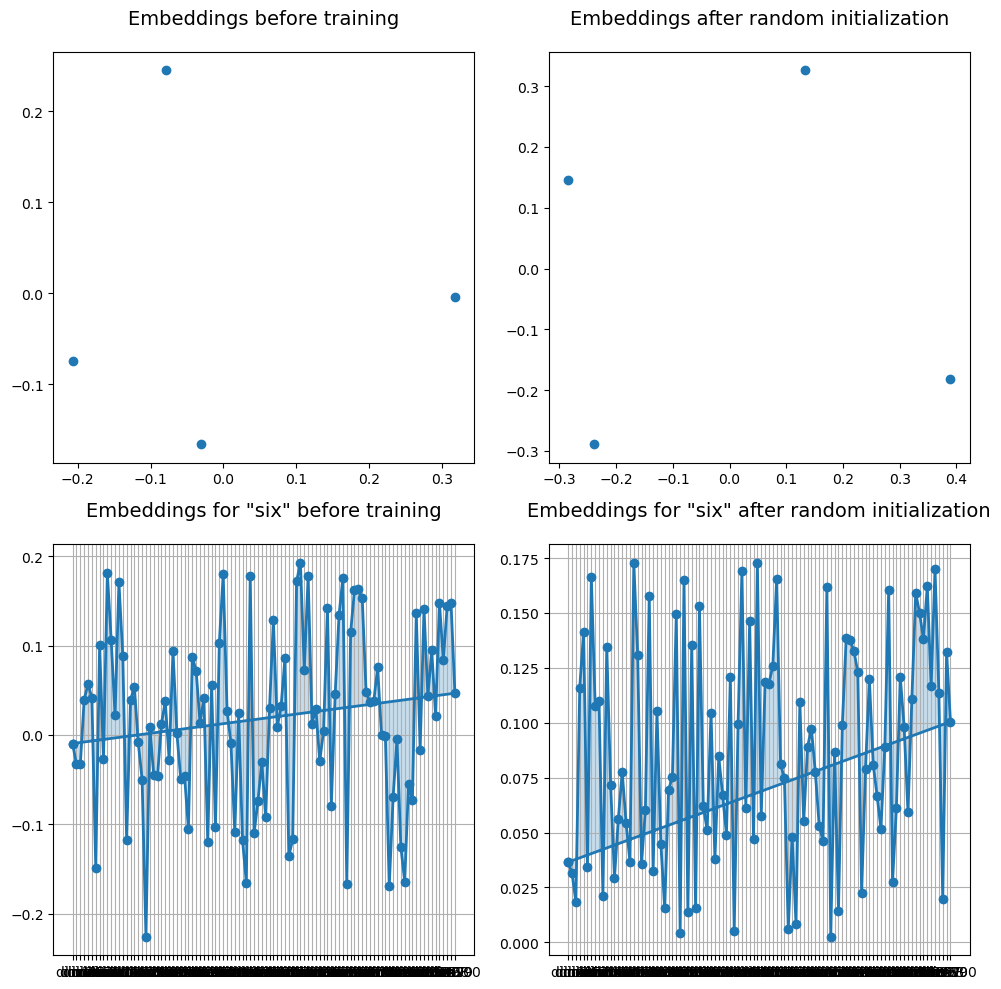

In [18]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize

# Plot embeddings before and after training
words = ['six', 'seven', 'eight', 'nine']
# Normalize embeddings for plotting
embeddings = np.array([six_embedding, seven_embedding, eight_embedding, nine_embedding])
embeddings = normalize(embeddings)

embeddings_random = np.array([six_embedding_random, seven_embedding_random, eight_embedding_random, nine_embedding_random])
embeddings_random = normalize(embeddings_random)

# Reduce dimensionality using PCA
pca = PCA(n_components=2, random_state=0)
embeddings_pca = pca.fit_transform(embeddings)

embeddings_random_pca = pca.fit_transform(embeddings_random)

# Radar plot
def radar_plot(ax, data, labels, title):
    angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False)
    data = np.concatenate((data, [data[0]]))
    angles = np.concatenate((angles, [angles[0]]))
    ax.plot(angles, data, 'o-', linewidth=2)
    ax.fill(angles, data, alpha=0.25)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels)
    ax.set_title(title, fontsize=14, pad=20)
    ax.grid(True)


# Plot embeddings before and after training
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0, 0].scatter(embeddings_pca[:, 0], embeddings_pca[:, 1])
axs[0, 0].set_title('Embeddings before training', fontsize=14, pad=20)
axs[0, 1].scatter(embeddings_random_pca[:, 0], embeddings_random_pca[:, 1])
axs[0, 1].set_title('Embeddings after random initialization', fontsize=14, pad=20)

labels = ['dim'+str(i) for i in range(1, 101)]
radar_plot(axs[1, 0], embeddings[0], labels, 'Embeddings for "six" before training')
radar_plot(axs[1, 1], embeddings_random[0], labels, 'Embeddings for "six" after random initialization')

plt.tight_layout()
plt.show()

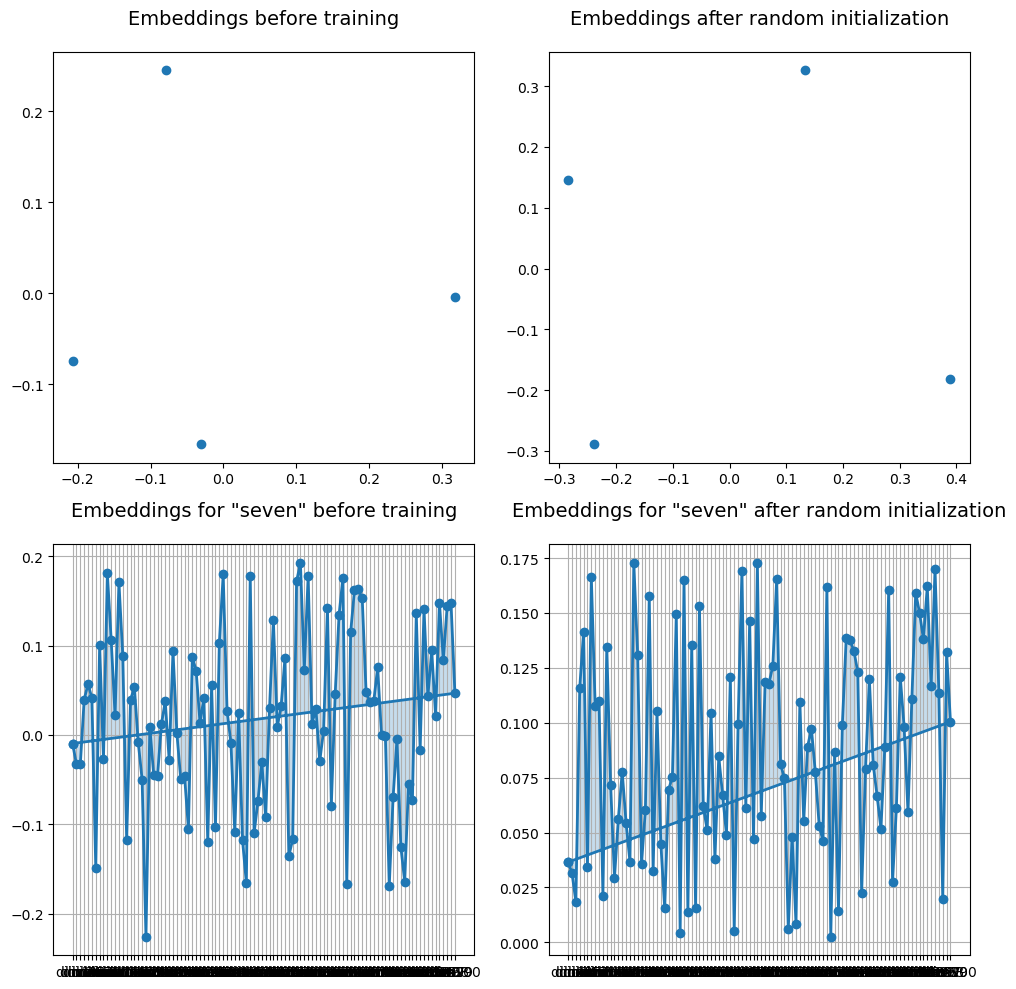

In [19]:
# Plot embeddings before and after training
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0, 0].scatter(embeddings_pca[:, 0], embeddings_pca[:, 1])
axs[0, 0].set_title('Embeddings before training', fontsize=14, pad=20)
axs[0, 1].scatter(embeddings_random_pca[:, 0], embeddings_random_pca[:, 1])
axs[0, 1].set_title('Embeddings after random initialization', fontsize=14, pad=20)

labels = ['dim'+str(i) for i in range(1, 101)]
radar_plot(axs[1, 0], embeddings[0], labels, 'Embeddings for "seven" before training')
radar_plot(axs[1, 1], embeddings_random[0], labels, 'Embeddings for "seven" after random initialization')

plt.tight_layout()
plt.show()

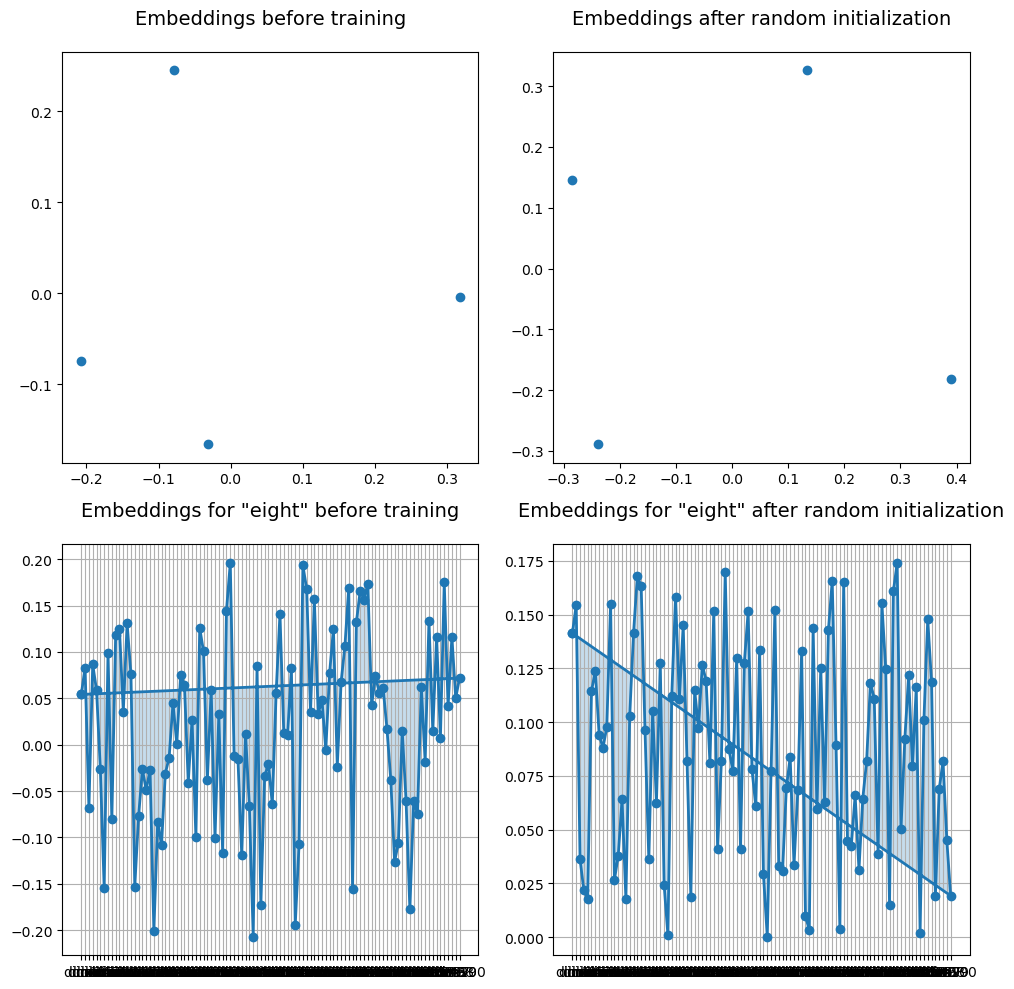

In [20]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0, 0].scatter(embeddings_pca[:, 0], embeddings_pca[:, 1])
axs[0, 0].set_title('Embeddings before training', fontsize=14, pad=20)
axs[0, 1].scatter(embeddings_random_pca[:, 0], embeddings_random_pca[:, 1])
axs[0, 1].set_title('Embeddings after random initialization', fontsize=14, pad=20)

labels = ['dim'+str(i) for i in range(1, 101)]
radar_plot(axs[1, 0], embeddings[2], labels, 'Embeddings for "eight" before training')
radar_plot(axs[1, 1], embeddings_random[2], labels, 'Embeddings for "eight" after random initialization')

plt.tight_layout()
plt.show()

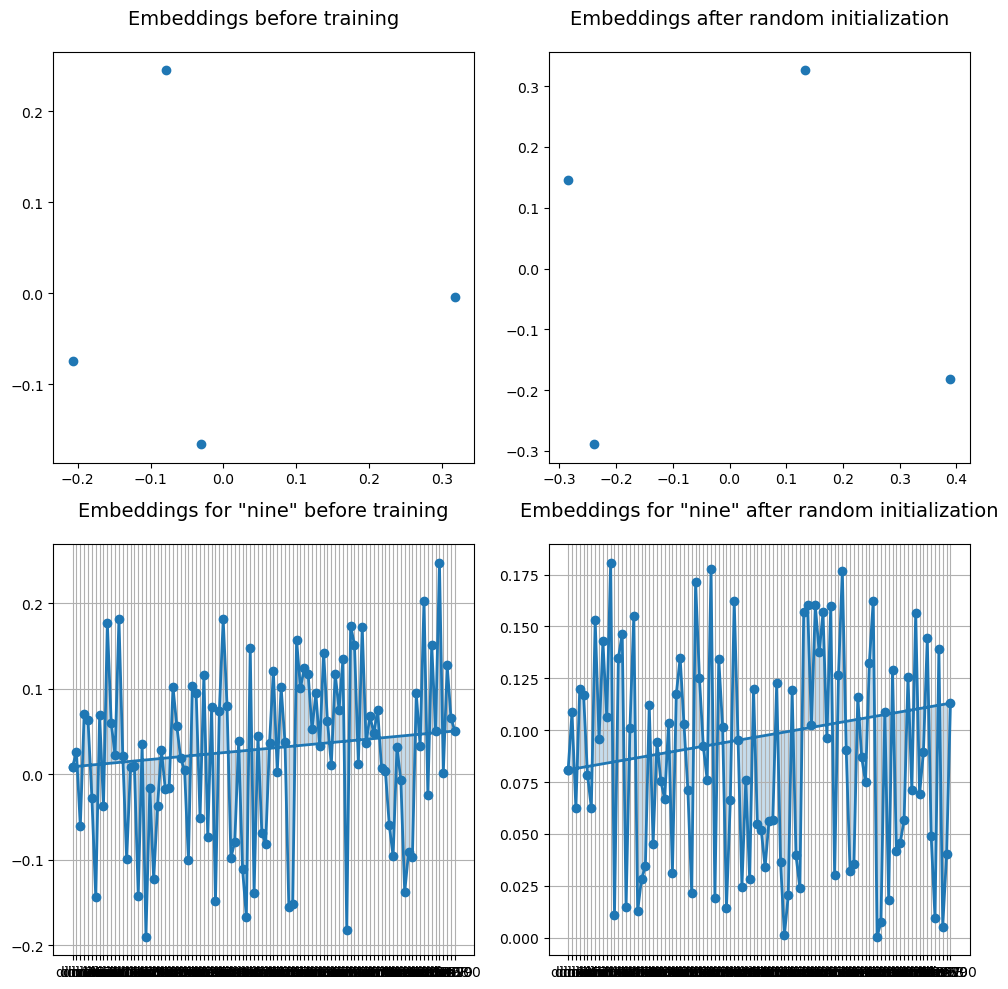

In [21]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0, 0].scatter(embeddings_pca[:, 0], embeddings_pca[:, 1])
axs[0, 0].set_title('Embeddings before training', fontsize=14, pad=20)
axs[0, 1].scatter(embeddings_random_pca[:, 0], embeddings_random_pca[:, 1])
axs[0, 1].set_title('Embeddings after random initialization', fontsize=14, pad=20)

labels = ['dim'+str(i) for i in range(1, 101)]
radar_plot(axs[1, 0], embeddings[3], labels, 'Embeddings for "nine" before training')
radar_plot(axs[1, 1], embeddings_random[3], labels, 'Embeddings for "nine" after random initialization')

plt.tight_layout()
plt.show()

<div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA">

**1.3.3 Embedding and Context Matrix**
    
<br />
    
Investigate the relation between the Embedding & Context matrix. Again use the `cosine_similarity()` function to find the average value across all the words in the embedding and context matrix, i.e:
    - For a word 'dog', find the embedding value, and context value.
    - Calculate the `cosine_similarity()` between the two
    - Repeat the same for every word in the vocabulary and calculate the average value of the `cosine_similarity()`

- Answer the following question and explain in less than 200 words:
    
**Question:** *The embedding and context matrices should be identical*
<br />
    
</div>

This is not true. Embedding and context matrices are two different entities.

An embedding matrix is a matrix that maps words or entities in a text to a vector of real numbers. The embedding matrix is used to represent words or entities in a high-dimensional space, where words with similar meanings are located closer to each other.

A context matrix, on the other hand, is a matrix that represents the context in which words occur. It is typically generated by counting the co-occurrence of words in a text corpus.

The two matrices are not the same and serve different purposes. The embedding matrix is used to represent the semantic meaning of words in a text, whereas the context matrix is used to capture the co-occurrence patterns of words.

In [22]:
# Your code here

from sklearn.metrics.pairwise import cosine_similarity

# Get the embedding and context weights from the model
embedding_weights = word2vec_model_loaded.get_layer('center_word_embedding').get_weights()[0]
context_weights = word2vec_model_loaded.get_layer('context_word_embedding').get_weights()[0]

# Calculate the average cosine similarity between the embedding and context matrix for each word in the vocabulary
cosine_similarities = []
for word, idx in tokenizer.word_index.items():
    # Subtract 1 from the index to account for the difference in indexing
    adjusted_idx = idx - 1
    
    # Ensure the index is within bounds before calculating the cosine similarity
    if 0 <= adjusted_idx < len(embedding_weights) and 0 <= adjusted_idx < len(context_weights):
        embedding_vector = embedding_weights[adjusted_idx]
        context_vector = context_weights[adjusted_idx]
        cosine_similarities.append(cosine_similarity([embedding_vector], [context_vector])[0][0])

avg_cosine_similarity = sum(cosine_similarities) / len(cosine_similarities)
print(f"Average cosine similarity between embedding and context matrix: {avg_cosine_similarity}")




Average cosine similarity between embedding and context matrix: 0.15350854117946


<div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA">

### **1.4 [5 points] LEARNING PHRASES**
    
As per the original paper by Mikolov et al. many phrases have a meaning that is not a simple composition of the meanings of its individual words. 
For eg. `new york` is one entity, however, as per our analysis above, we have two separate entities `new` & `york` which can have different meanings independently.    
To learn vector representation for phrases, we first find words that
appear frequently together, and infrequently in other contexts.
    
As per the analysis in the paper, we can use a formula to rank commonly used word pairs, and take the first 100 commonly occuring pairs.
$$\operatorname{score}\left(w_{i}, w_{j}\right)=\frac{\operatorname{count}\left(w_{i} w_{j}\right)-\delta}{\operatorname{count}\left(w_{i}\right) \times \operatorname{count}\left(w_{j}\right)}$$

**NOTE:** For simplicity of analysis, we take the discounting factor $\delta$ as 0, and take bi-gram combinations. You can experiment with tri-grams for word pairs such as `New_York_Times`.     
<br /><br />

    
**1.4.1 Find 100 most common bi-grams**

From the tokenized data above, find the count for each bigram pair.
    
For each such pair, find the score associated with each token pair using the formula above.
    
 Pick the top 100 pairs based on the score. (Higher the better). To understand the `score()` function we suggest you read the paper mentioned above.
    
Replace the original `text8` file with the pairs as one entity. For e.g., if `prime,minister` is a commonly occuring pair, replace `... prime minister ...' in the original corpus to a single entity `prime_minister`. Do this for all 100 pairs.
<br /><br />
    
</div>

In [23]:
# Download
urllib.request.urlretrieve("https://github.com/dlops-io/datasets/releases/download/v1.0/text8.zip", "text8.zip")
# Get the training data again
filename = 'text8.zip'
with zipfile.ZipFile(filename) as f:
# Read the data into a list of strings.
    super_text = tf.compat.as_str(f.read(f.namelist()[0]))

In [24]:
import nltk
from collections import Counter

def build_dataset(words, n_words):
    """Process raw inputs into a dataset.""" 
    tokenizer = Tokenizer(num_words=n_words, oov_token="<OOV>")
    tokenizer.fit_on_texts(words)

    # Tokenize the words
    tokenized_data = tokenizer.texts_to_sequences(words)
    
    # Count of each token
    count = tokenizer.word_counts
    count = sorted(count.items(), key=lambda x: x[1], reverse=True)
    count = count[:n_words]

    # Dictionaries for word-to-token and token-to-word mapping
    word_to_token = tokenizer.word_index
    token_to_word = tokenizer.index_word
    

    return tokenized_data, count, word_to_token, token_to_word

In [25]:
# Make sure to use lower case and split as before
corpus = super_text.lower().split()
data, count, dictionary, reversed_dictionary = build_dataset(corpus, 11500)

In [26]:
# Flatten the tokenized sentences into a list of tokenized words
flat_data = [word for sentence in data for word in sentence]

# Calculate bigrams for the flat list of tokenized words
bigrams = list(nltk.bigrams(flat_data))

# Calculate bigram frequencies
bigram_freq = Counter(bigrams)

# Find the 100 most common bigrams
top_100_bigrams = bigram_freq.most_common(100)

# Calculate scores for each bigram in the top 100
bigram_scores = {}
delta = 0
for bigram, bigram_count in top_100_bigrams:
    word_i = reversed_dictionary[bigram[0]]
    word_j = reversed_dictionary[bigram[1]]
    word_i_count = count[dictionary[word_i] - 1][1]
    word_j_count = count[dictionary[word_j] - 1][1]
    score = (bigram_count - delta) / (word_i_count * word_j_count)
    bigram_scores[(word_i, word_j)] = score

print("Top 100 bigrams and their scores:")
for bigram, score in bigram_scores.items():
    print(f"{bigram}: {score}")

Top 100 bigrams and their scores:
('<OOV>', '<OOV>'): 2.185029461896185e-07
('of', 'the'): 6.478047265494614e-07
('one', 'nine'): 2.163515296414027e-06
('the', '<OOV>'): 2.3054104953002694e-07
('in', 'the'): 4.846345408490912e-07
('zero', 'zero'): 1.4482298050276497e-06
('<OOV>', 'and'): 2.038121218126815e-07
('of', '<OOV>'): 1.5878487900900686e-07
('and', '<OOV>'): 1.4654108719049325e-07
('<OOV>', 'the'): 9.994344101502379e-08
('two', 'zero'): 1.2159285098169474e-06
('<OOV>', 'in'): 1.4374047954079113e-07
('to', 'the'): 3.12384060062332e-07
('<OOV>', 'of'): 1.1067859652127468e-07
('a', '<OOV>'): 1.299552450667248e-07
('nine', 'nine'): 1.0916500262732592e-06
('one', 'eight'): 8.895699426873372e-07
('in', 'one'): 3.1628261919406223e-07
('and', 'the'): 1.5342712644703476e-07
('to', '<OOV>'): 1.0673672504187726e-07
('on', 'the'): 6.508142252878555e-07
('<OOV>', 'one'): 7.049186941791963e-08
('nine', 'eight'): 1.2123473213595922e-06
('<OOV>', 'to'): 9.652137439577601e-08
('by', 'the'): 3.9

In [27]:
# Your code here
# Function to replace bigrams with single entity representation
def replace_bigrams_with_single_entity(text, bigram_pairs):
    for bigram in bigram_pairs:
        bigram_str = f"{bigram[0]} {bigram[1]}"
        bigram_entity = f"{bigram[0]}_{bigram[1]}"
        text = text.replace(bigram_str, bigram_entity)
    return text

# Get the top 100 bigram pairs as a list
top_bigram_pairs = [bigram for bigram, _ in bigram_scores.items()]

# Replace bigrams in the original text with single entity representations
modified_text = replace_bigrams_with_single_entity(super_text, top_bigram_pairs)

# Print a sample of the modified text
print(modified_text[:1000])


 anarchism originated as_a term of_abuse first used against early working class radicals including the diggers of_the english revolution and_the sans culottes of_the french revolution whilst the term is still used in_a pejorative way to describe any act that used violent means to destroy the organization of society it has_also been taken up as_a positive label by self defined anarchists the word anarchism is derived from_the greek without archons ruler chief king anarchism as_a political philosophy is_the belief that rulers are unnecessary and should be abolished although there are differing interpretations of what this means anarchism also refers to related social movements that advocate the elimination of_authoritarian institutions particularly the state the word anarchy as most anarchists use it does not imply chaos nihilism or anomie but rather a harmonious anti authoritarian society in place of what are regarded as_authoritarian political structures and coercive economic instituti

<div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA">

**1.4.2 Retrain word2vec**    
With the new corpus generated as above, build the dataset, use skipgrams and retrain your word2vec with a sufficiently large vocabulary.
    
Use the `most_similar()` function defiend above to find the entities most similar to `united_kingdom`
    
Compare the above with separate tokens for `united` & `kingdom` and the sum of the vectors (to get this, you may need a sufficiently large vocabulary (>2000).
<br /> <br />
    
</div>

In [28]:
# Your code here

from tensorflow.keras.preprocessing.sequence import skipgrams, make_sampling_table

# Parameters
window_size = 3
negative_samples = 1.0
vocab_size = 11500

# Create a word-frequency rank-based probabilistic sampling table
sampling_table = make_sampling_table(vocab_size)

# Generate skipgrams
pairs, labels = skipgrams(
    data,
    vocabulary_size=vocab_size,
    window_size=window_size,
    negative_samples=negative_samples,
    sampling_table=sampling_table,
)

# Print 10 pairs of center and context words with their associated labels
for i in range(10):
    center_idx, context_idx = pairs[i]
    
    # Handle cases where the indices are wrapped in lists
    if isinstance(center_idx, list):
        center_idx = center_idx[0]
    if isinstance(context_idx, list):
        context_idx = context_idx[0]

    center_word = reversed_dictionary[center_idx]
    context_word = reversed_dictionary[context_idx]
    label = labels[i]
    print(f"({center_word}, {context_word}): {label}")

(board, letterman): 0
(mccarthy, mob): 0
(governors, skater): 0
(essays, <OOV>): 1
(socialists, power): 1
(grt, five): 1
(argument, argument): 1
(occasions, rather): 1
(is, jun): 0
(compare, representation): 0


In [29]:
# Model parameters
embedding_dim = 100
epochs = 5

# Input layers for center and context words
center_word_input = Input(shape=(1,), name="center_word_input")
context_word_input = Input(shape=(1,), name="context_word_input")

# Embedding layers for center and context words
center_word_embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=1, name="center_word_embedding")(center_word_input)
context_word_embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=1, name="context_word_embedding")(context_word_input)

# Dot product of center and context word embeddings
dot_product = Dot(axes=-1, normalize=False, name="dot_product")([center_word_embedding, context_word_embedding])
dot_product = Reshape((1,), name="dot_product_reshape")(dot_product)

# Dense output layer with sigmoid activation
output = Dense(1, activation="sigmoid", name="output")(dot_product)

# Create the model
word2vec_model = Model(inputs=[center_word_input, context_word_input], outputs=output)
word2vec_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Print model summary
word2vec_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 center_word_input (InputLayer)  [(None, 1)]         0           []                               
                                                                                                  
 context_word_input (InputLayer  [(None, 1)]         0           []                               
 )                                                                                                
                                                                                                  
 center_word_embedding (Embeddi  (None, 1, 100)      1150000     ['center_word_input[0][0]']      
 ng)                                                                                              
                                                                                            

In [30]:
# Flatten the single-element lists in pairs
flat_pairs = [(center[0] if isinstance(center, list) else center,
               context[0] if isinstance(context, list) else context)
              for center, context in pairs]

# Convert pairs and labels to NumPy arrays
x = np.array(flat_pairs, dtype=np.int32)
y = np.array(labels, dtype=np.float32)

In [31]:
K.clear_session()

In [32]:
#word2vec_model.fit([x[:, 0], x[:, 1]], y, epochs=epochs, batch_size=256, verbose=1)

In [33]:
#Save the model weights
#word2vec_model.save_weights("word2vec_retrained_model_weights.h5")
word2vec_model.load_weights("word2vec_retrained_model_weights.h5")

In [34]:
# Extract word embeddings
word_embeddings = word2vec_model.get_layer("center_word_embedding").get_weights()[0]


word_to_id = {word: idx for idx, word in reversed_dictionary.items()}
id_to_word = {idx: word for idx, word in reversed_dictionary.items()}

word_to_search = "united_kingdom"

if word_to_search in word_to_id:
    similar_words = most_similar(word_to_search, word_embeddings, word_to_id, id_to_word, n=5)
    print(f"Words most similar to '{word_to_search}':", similar_words)
else:
    print(f"The word '{word_to_search}' is not in the dictionary.")


The word 'united_kingdom' is not in the dictionary.


In [35]:
words_to_search = ["united", "kingdom"]

# Check if both words are in the dictionary
if all(word in word_to_id for word in words_to_search):
    # Find the most similar words for 'united' and 'kingdom'
    similar_united = most_similar(words_to_search[0], word_embeddings, word_to_id, id_to_word, n=5)
    similar_kingdom = most_similar(words_to_search[1], word_embeddings, word_to_id, id_to_word, n=5)

    print(f"Words most similar to '{words_to_search[0]}':", similar_united)
    print(f"Words most similar to '{words_to_search[1]}':", similar_kingdom)

    # Find the most similar words for the sum of 'united' and 'kingdom' vectors
    united_embedding = word_embeddings[word_to_id[words_to_search[0]]]
    kingdom_embedding = word_embeddings[word_to_id[words_to_search[1]]]
    sum_embedding = united_embedding + kingdom_embedding

    # Define a custom similarity function to use the sum_embedding
    def most_similar_sum(embedding, word_embeddings, id_to_word, n=5):
        similarities = cosine_similarity([embedding], word_embeddings)[0]
        top_n_indices = similarities.argsort()[-n-1:-1][::-1]
        return [id_to_word[i] for i in top_n_indices]

    similar_sum = most_similar_sum(sum_embedding, 
                                   word_embeddings, 
                                   id_to_word, 
                                   n=5)
    print(f"Words most similar to the sum of '{words_to_search[0]}' and '{words_to_search[1]}':", similar_sum)

else:
    print("One or both words are not in the dictionary.")


Words most similar to 'united': ['states', 'nations', 'delegates', 'commissioners', 'presidents']
Words most similar to 'kingdom': ['princes', 'principality', 'galicia', 'nominally', 'ruled']
Words most similar to the sum of 'united' and 'kingdom': ['kingdom', 'dominion', 'ireland', 'nominally', 'states']


**This concludes HW5-209. Thank you!**